# DEAP Dataset + Spectrogram + CNN2D (2 layers)

In this part, we shall try inputting the spectrogram into 2 layers of CNN2D.

*Note that we will be only predicting the valence.  Feel free to work on the arousal yourself.*

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os, pickle

# setting seed so that splitting process and training process can be reproduce
torch.manual_seed(1)

import numpy as np

#refactoring components
#maybe you want to take a look at these components, because we will be using them in the future series
from components.dataset import Dataset, SpecDataset
from components.helper import getLoaders, count_parameters, plot_performance
from components.train import train, evaluate, initialize_weights

Set cuda accordingly.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Configured device: ", device)

Configured device:  cuda


## 1. Loading the SpecDataset

Here we gonna just refactor the code and put into the <code>components/dataset.py</code> folder

In [3]:
path = "data"  #create a folder "data", and inside put s01.dat,....,s32.dat inside from the preprocessed folder from the DEAP dataset

sample_rate = 128
window_size = int(sample_rate)  #1s
step_size = sample_rate * 0.5 #0.5s

In [4]:
#def __init__(self, path, stim, sample_rate, window_size, step_size, segments):
#12 here means breaking 60s video into 12 segments
dataset = SpecDataset(path, "Valence", sample_rate, window_size, step_size, 12)

data  = dataset[:]['data']
label = dataset[:]['label']

print("Data shape: " , data.shape)  # batches, channels, height, width
print("Label shape: ", label.shape)  #two classes of valence

Data shape:  torch.Size([15360, 32, 9, 65])
Label shape:  torch.Size([15360, 1])


## 2. Defining the Model

Convolution is a very simple idea.  For those who want to complete tutorial on CNN, you can visit my another tutorial on CNN here -> https://github.com/chaklam-silpasuwanchai/Python-for-Data-Science/blob/master/Lectures/03-PyTorch/03%20-%20Deep%20Learning%20-%20PyTorch%20-%20Convolutional%20Neural%20Network.ipynb

### Getting shape so we can make sure our convolution always work dynamically

In [5]:
conv2d1 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
maxpool1 = nn.MaxPool2d(kernel_size=2)

conv2d2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
maxpool2 = nn.MaxPool2d(kernel_size=2)

In [6]:
out = conv2d1(data)
out.shape

torch.Size([15360, 64, 9, 65])

In [7]:
out = maxpool1(out)
out.shape

torch.Size([15360, 64, 4, 32])

In [8]:
out = conv2d2(out)
out.shape

torch.Size([15360, 128, 4, 32])

In [9]:
out = maxpool2(out)
print(out.shape)
final_shape = out.shape

torch.Size([15360, 128, 2, 16])


### Model Definition

In [10]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, input_dim=32, output_dim=1):
        super(ConvNet, self).__init__()
        
        #using sequential helps bind multiple operations together
        self.layer1 = nn.Sequential(
            #in_channel = 32, #out_channel = 64
            nn.Conv2d(input_dim, input_dim*2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(input_dim*2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(input_dim*2, input_dim*4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(input_dim*4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        
        self.fc = nn.Linear(final_shape[1]*final_shape[2]*final_shape[3], output_dim)
        self.drop_out = nn.Dropout(p=0.2)  #zeroed 0.2% data
        #after fc will be of shape [batch, 1]
        
    def forward(self, x):
        #x shape: [batch, in_channel, img_width, img_height]
        out = self.layer1(x)
        out = self.drop_out(out)
        out = self.layer2(out)
        out = self.drop_out(out)
        
        out = out.reshape(out.size(0), -1)   #can also use .view()
        #we squeeze so that it can be inputted into the fc layer
        out = self.fc(out)
        #after fc layer: shape: [batch, 1]
        return out

**Model init**: Let's init the class instance and create a workabout model.

In [11]:
input_dim     = 32 #we got 32 EEG channels
output_dim    = 1  #we got 2 classes for our labels

#define the model
model = ConvNet(input_dim, output_dim)

#send to cuda so we can use the GPU
model = model.to(device)  

#apply weights
model.apply(initialize_weights)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
  (drop_out): Dropout(p=0.2, inplace=False)
)

**Param count**: Let's also check the number of parameters used

In [12]:
print(f'The model {type(model).__name__} has {count_parameters(model):,} trainable parameters')# Train the model

The model ConvNet has 96,833 trainable parameters


**Unit test**: Let's define a simple unit test, inputing some mock EEG data and see whether we got the desired output as 4 classes.

In [13]:
mock_batch_size = 2   
mock_input_dim  = 32   
mock_height     = data.shape[2]  #need to use real shape to make sure CNN layers work
mock_width      = data.shape[3]

#note that our model first layer is conv1d which expects (batch, channel, height, width)
mock_eegdata = torch.rand(mock_batch_size, mock_input_dim, mock_height, mock_width).to(device)

#let's try run the model by simply inserting the mockdata into the model; very similar to .fit
predictions = model(mock_eegdata)

#let's try to see the predictions whether it really outputs 2 unique classes - 0 and 1
print("Prediction shape: ", predictions.shape)
print("Predictions: ", predictions)

#simple unit test
assert predictions.shape[0] == mock_batch_size
assert predictions.shape[1] == output_dim

Prediction shape:  torch.Size([2, 1])
Predictions:  tensor([[0.5552],
        [0.6666]], device='cuda:0', grad_fn=<AddmmBackward>)


## 3. Training

### I. Batch Iterators

To make it easier to manage, I have put this into our <code>components/helper.py</code>.

In [14]:
train_loader, val_loader, test_loader = getLoaders(dataset=dataset, batch_size=16)

Full Dataset size:  15360
Train Dataset size: 10752
Valid Dataset size: 3072
Test Dataset size:  1536



### II. Optimizers

Optimizer simply refers to the one that gonna take care of the backpropagation process.  The commonly used optimizer is SGD and Adam, both are quite interchangeable.  Here we gonna use Adam.  In order to backpropagate, we gonna define a loss function using cross entropy loss, which is a common loss function for multi-class purposes.

In [15]:
import torch.optim as optim

num_epochs = 50

lr = 0.0001

#can also try SGD which should not make too much of a difference
optimizer = optim.Adam(model.parameters(), lr=lr) 

#combine sigmoid with binary entropy; binary entropy is used for binary classification
criterion = nn.BCEWithLogitsLoss() 

### III. Let's train!

In [16]:
model_saved_name = "models/DEAP_Specgram_CNN2D_2layers.pt"

#trainer(num_epochs, model, train_loader, val_loader, optimizer, criterion, model_name, device, seq_len_first=False)
train_losses, valid_losses, train_accs, valid_accs = train(num_epochs, model, train_loader, val_loader, optimizer, criterion, model_saved_name, device)

Epoch: 01 | Epoch Time: 0m 3s
	 Train Loss: 0.795 | Train Acc: 53.90%
	 Val. Loss: 0.678  |  Val. Acc: 57.98%
Epoch: 02 | Epoch Time: 0m 3s
	 Train Loss: 0.738 | Train Acc: 57.29%
	 Val. Loss: 0.689  |  Val. Acc: 60.48%
Epoch: 03 | Epoch Time: 0m 3s
	 Train Loss: 0.701 | Train Acc: 59.77%
	 Val. Loss: 0.636  |  Val. Acc: 63.80%
Epoch: 04 | Epoch Time: 0m 3s
	 Train Loss: 0.680 | Train Acc: 60.94%
	 Val. Loss: 0.627  |  Val. Acc: 64.52%
Epoch: 05 | Epoch Time: 0m 3s
	 Train Loss: 0.656 | Train Acc: 63.19%
	 Val. Loss: 0.620  |  Val. Acc: 65.72%
Epoch: 06 | Epoch Time: 0m 3s
	 Train Loss: 0.642 | Train Acc: 64.75%
	 Val. Loss: 0.597  |  Val. Acc: 67.55%
Epoch: 07 | Epoch Time: 0m 3s
	 Train Loss: 0.616 | Train Acc: 66.19%
	 Val. Loss: 0.582  |  Val. Acc: 69.86%
Epoch: 08 | Epoch Time: 0m 3s
	 Train Loss: 0.607 | Train Acc: 67.15%
	 Val. Loss: 0.580  |  Val. Acc: 69.30%
Epoch: 09 | Epoch Time: 0m 3s
	 Train Loss: 0.590 | Train Acc: 68.40%
	 Val. Loss: 0.566  |  Val. Acc: 70.93%
Epoch: 10 

Let's plot the losses and acc for easier inspection

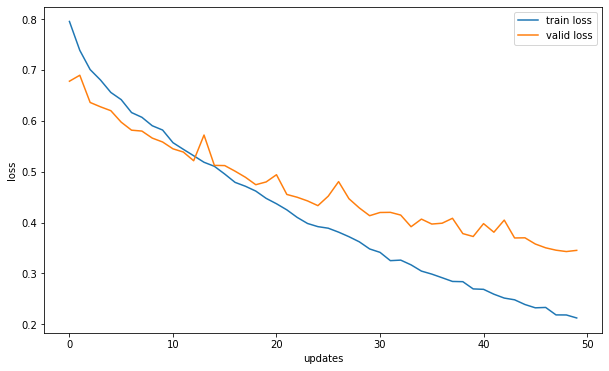

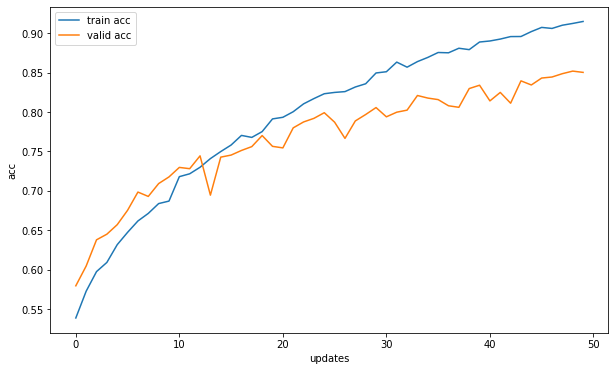

In [17]:
plot_performance(train_losses, valid_losses, "loss")
plot_performance(train_accs, valid_accs, "acc")

## 4. Evaluation on test set

In [18]:
model.load_state_dict(torch.load(model_saved_name))
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.334 | Test Acc: 86.20%


## Final Verdict



The accuracy is between LSTM and CNN1D_LSTM.  However, one important note is the relatively much lesser parameters.  In addition, if we train for even longer, perhaps we could achieve even better accuracy.

In simple words, spectrograms are a very lean way to achieve reasonable accuracy.

In the next tutorial, let's try to add two more layers of convolution and see whether there is any accuracy increased.